<a href="https://colab.research.google.com/github/Korniev/Machine-Learning-projects/blob/main/ClassReport_augm_image_classification_tiny_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries:

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import zipfile
import os
import shutil

Upload the file to Google Colab and list the uploaded files to verify:

In [6]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')

Saving archive.zip to archive.zip
Uploaded file: archive.zip


Extract the uploaded file and Assuming the uploaded file is named 'archive.zip':

In [7]:
zip_path = '/content/archive.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

Verify the extracted files:

In [8]:
!ls /content/tiny-imagenet-200

test  train  val  wnids.txt  words.txt


Let's make some manipulations for dataset

In [9]:
val_dir = '/content/tiny-imagenet-200/val'
val_images_dir = os.path.join(val_dir, 'images')
val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')


Create subdirectories for each class and then remove the now-empty images directory:

In [10]:
with open(val_annotations_file, 'r') as f:
    for line in f.readlines():
        parts = line.strip().split('\t')
        image_name = parts[0]
        class_name = parts[1]

        class_dir = os.path.join(val_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        source = os.path.join(val_images_dir, image_name)
        destination = os.path.join(class_dir, image_name)
        shutil.move(source, destination)

shutil.rmtree(val_images_dir)

Define paths:

In [11]:
train_dir = './tiny-imagenet-200/train'
val_dir = './tiny-imagenet-200/val'

Define image data generators with enhanced data augmentation:

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)


Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


Load the pre-trained EfficientNetB3 model:

In [13]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Add custom layers on top:

In [14]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(200, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

Fine-tune the entire model by unfreeze the last 100 layers:

In [15]:
for layer in base_model.layers[-100:]:
    layer.trainable = True

Compile the model:

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Define a learning rate scheduler and callbacks:

In [17]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.000001)

Train the model:

In [18]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 381s 85ms/step - accuracy: 0.0464 - loss: 15.4556 - val_accuracy: 0.3278 - val_loss: 7.1360 - learning_rate: 1.0000e-04
Epoch 2/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 256s 82ms/step - accuracy: 0.2401 - loss: 6.7960 - val_accuracy: 0.4305 - val_loss: 3.9924 - learning_rate: 1.0000e-04
Epoch 3/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 256s 80ms/step - accuracy: 0.3413 - loss: 4.1173 - val_accuracy: 0.4728 - val_loss: 3.0772 - learning_rate: 1.0000e-04
Epoch 4/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 256s 82ms/step - accuracy: 0.3887 - loss: 3.2824 - val_accuracy: 0.4950 - val_loss: 2.7391 - learning_rate: 1.0000e-04
Epoch 5/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 256s 80ms/step - accuracy: 0.4283 - loss: 2.9064 - val_accuracy: 0.5097 - val_loss: 2.6449 - learning_rate: 1.0000e-04
Epoch 6/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 262s 84ms/step - accuracy: 0.4496 - loss: 2.7235 - val_accuracy: 0.5190 - val_loss: 2.5658 - learning_rate: 1.0000e-04
Epoch 7/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 25

Let's evaluate the model:

In [19]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5796 - loss: 2.0800
Validation Accuracy: 0.5813000202178955


**Let's visualize prediction:**

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model

In [28]:
# Create a mapping from synset IDs to human-readable labels
def load_class_labels(filepath):
    class_labels = {}
    with open(filepath, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split('\t')
            synset_id = parts[0]
            label = parts[1]
            class_labels[synset_id] = label
    return class_labels

class_labels = load_class_labels('/content/tiny-imagenet-200/words.txt')


Define a function to load, preprocess, and predict an image:

In [29]:
def predict_and_visualize(image_path, model, class_indices, class_labels):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Decode the prediction
    class_labels_reverse = {v: k for k, v in class_indices.items()}
    predicted_synset_id = class_labels_reverse[predicted_class_index]
    predicted_class_label = class_labels[predicted_synset_id]

    # Print prediction probabilities for debugging
    print(f"Predictions: {predictions}")
    print(f"Predicted class index: {predicted_class_index}")
    print(f"Predicted synset ID: {predicted_synset_id}")
    print(f"Predicted class label: {predicted_class_label}")

    # Visualize the result
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_label} (Class {predicted_class_index})')
    plt.axis('off')
    plt.show()

Assume 'class_indices' is a dictionary mapping class names to their index:

In [30]:
class_indices = train_generator.class_indices

Test the function with an example image:

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predictions: [[0.00461535 0.00445463 0.00244321 0.00607749 0.00679161 0.00494206
  0.00351348 0.00658765 0.002254   0.00554549 0.00656884 0.00375904
  0.00420156 0.00431979 0.00696166 0.00841614 0.00727544 0.00444519
  0.00560328 0.00359648 0.00425274 0.0060259  0.0049207  0.00929257
  0.00539108 0.00416506 0.00490678 0.00565874 0.00495369 0.0042571
  0.00385838 0.00601738 0.00610546 0.0036484  0.00349594 0.00407618
  0.00520231 0.00577632 0.00499986 0.00747732 0.00596848 0.00478922
  0.00454524 0.00348378 0.00352593 0.00435942 0.00548556 0.00393524
  0.00352157 0.00618018 0.00504331 0.00419932 0.00488107 0.00437323
  0.00491648 0.00383361 0.00434589 0.00493827 0.00574497 0.00362222
  0.00446061 0.00433168 0.00335864 0.00544969 0.00370858 0.00501509
  0.00631976 0.00592712 0.00564635 0.00661959 0.00492685 0.00813254
  0.00403024 0.00388272 0.00519947 0.00615624 0.0044028  0.00609878
  0.0048124  0.00364653 0.00642113 0.00533551 0.00458061 0.00459459


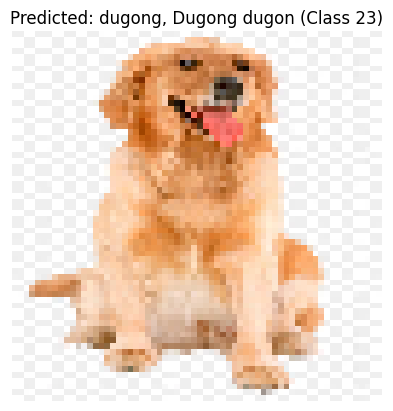

In [68]:
predict_and_visualize('/content/1.png', model, class_indices, class_labels)

Get true labels and predicted labels for the validation set

In [69]:
true_labels = []
predicted_labels = []

for images, labels in val_generator:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))
    if len(true_labels) >= val_generator.samples:
        break

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

Generate the classification report

In [70]:
from sklearn.metrics import classification_report

In [71]:
report = classification_report(true_labels, predicted_labels, target_names=list(class_indices.keys()))
print(report)

              precision    recall  f1-score   support

   n01443537       0.00      0.00      0.00        50
   n01629819       0.00      0.00      0.00        50
   n01641577       0.00      0.00      0.00        50
   n01644900       0.00      0.00      0.00        50
   n01698640       0.00      0.00      0.00        50
   n01742172       0.00      0.00      0.00        50
   n01768244       0.00      0.00      0.00        50
   n01770393       0.00      0.00      0.00        50
   n01774384       0.00      0.00      0.00        50
   n01774750       0.00      0.00      0.00        50
   n01784675       0.00      0.00      0.00        50
   n01855672       0.00      0.00      0.00        50
   n01882714       0.00      0.00      0.00        50
   n01910747       0.00      0.00      0.00        50
   n01917289       0.00      0.00      0.00        50
   n01944390       0.00      0.00      0.00        50
   n01945685       0.00      0.00      0.00        50
   n01950731       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the classification report, let’s assume identified classes with an F1-score lower than 0.50.

Assume we have true_labels and predicted_labels from previous steps:

In [43]:
report_dict = classification_report(true_labels, predicted_labels, target_names=list(class_indices.keys()), output_dict=True)

Identify Poor Performing Classes:

In [44]:
def get_poor_performing_classes(report_dict, threshold=0.5):
    poor_classes = []
    for class_name, metrics in report_dict.items():
        if class_name not in ["accuracy", "macro avg", "weighted avg"]:
            if metrics["f1-score"] < threshold:
                poor_classes.append(class_name)
    return poor_classes

# Define the threshold for F1-score
f1_threshold = 0.5

# Get the list of poor performing classes
poor_classes = get_poor_performing_classes(report_dict, f1_threshold)
print(f"Poor performing classes: {poor_classes}")


Poor performing classes: ['n01742172', 'n02085620', 'n02123045', 'n02124075', 'n02403003', 'n02730930', 'n02788148', 'n02791270', 'n02795169', 'n02814533', 'n02906734', 'n02909870', 'n02948072', 'n02963159', 'n02977058', 'n02988304', 'n02999410', 'n03100240', 'n03126707', 'n03250847', 'n03255030', 'n03404251', 'n03424325', 'n03617480', 'n03637318', 'n03763968', 'n03770439', 'n03814639', 'n03838899', 'n03902125', 'n03970156', 'n03976657', 'n03983396', 'n04023962', 'n04067472', 'n04259630', 'n04275548', 'n04356056', 'n04371430', 'n04376876', 'n04501370', 'n04507155', 'n04532106', 'n04560804', 'n04597913', 'n06596364', 'n07579787', 'n07711569', 'n09246464', 'n09332890']


Apply Different Augmentation Strategies Based on Class Performance:

We can create a separate data generator with more aggressive augmentations for these classes.

In [59]:
# Define paths
train_dir = './tiny-imagenet-200/train'
val_dir = './tiny-imagenet-200/val'

# Define image data generators with enhanced data augmentation
normal_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

aggressive_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest'
)



In [60]:
def get_augmented_generator(directory, poor_classes, batch_size, target_size):
    normal_generator = normal_augmentation.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    aggressive_generators = []
    for class_name in poor_classes:
        class_path = os.path.join(directory, class_name)
        generator = aggressive_augmentation.flow_from_directory(
            directory,
            classes=[class_name],  # Only include the specific class
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True
        )
        aggressive_generators.append(generator)

    return normal_generator, aggressive_generators

In [61]:
normal_generator, aggressive_generators = get_augmented_generator(train_dir, poor_classes, batch_size=32, target_size=(64, 64))

Found 100000 images belonging to 200 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 i

Combine augmented generators into one:

In [62]:
def combined_generator(normal_gen, aggressive_gens):
    while True:
        # Get a batch from the normal generator
        normal_data, normal_labels = next(normal_gen)
        yield normal_data, normal_labels

        # Get batches from each aggressive generator
        for gen in aggressive_gens:
            try:
                data, labels = next(gen)
                yield data, labels
            except StopIteration:
                continue

train_generator = combined_generator(normal_generator, aggressive_generators)

Validation generator remains the same:

In [63]:
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Found 10000 images belonging to 200 classes.


In [64]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Data batch shape: (32, 64, 64, 3)
Labels batch shape: (32, 200)


Now we can retrain the Model:

In [65]:
# Load the EfficientNetB3 base model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(200, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tune the last 100 layers of the base model
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Compile the model with a standard learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
# Define the learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.000001)

Calculate steps per epoch:

In [ ]:
steps_per_epoch = len(normal_generator) + sum(len(gen) for gen in aggressive_generators)

Continue with trained model:

In [67]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

Epoch 1/20


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 200)

Evaluate the model

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy}')

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Also we can adjust the class weights to give more importance to the poor performing classes:

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(true_labels),
    y=true_labels
)
class_weights_dict = dict(enumerate(class_weights))

# Compile the model with class weights
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)
